# NLP.F2501 Course Project 1 (Word embeddings and RNNs)

Nevin Helfenstein

# Introduction

In this notebook, I present my solution to the CommonsenseQA task. I'll train a model using word embeddings, RNNs, and other NLP techniques to achieve the best possible performance.

## Dataset Description

The CommonsenseQA dataset [(Talmor et al., 2019)](https://aclanthology.org/N19-1421/) contains 12,247 multiple-choice questions specifically designed to test commonsense reasoning. Unlike standard QA tasks, these questions require prior knowledge about how concepts relate in the real world.

Questions were created by extracting related concepts from ConceptNet and having crowd-workers author questions that require distinguishing between them. This methodology produced challenging questions that often cannot be answered through simple pattern matching.

The best baseline in the original paper (BERT-large) achieved only 56% accuracy compared to human performance of 89%, shwoing the difficulty of encoding human-like commonsense reasoning.

# Setup

First we import all the needed libraries

In [ ]:
import torch
import nltk
import wandb

import gensim
import pandas as pd
import seaborn as sns
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from torch.utils.data import Dataset, DataLoader
from matplotlib_venn import venn2


from datasets import load_dataset
from huggingface_hub import hf_hub_download

from collections import Counter, defaultdict
from datetime import datetime

import functools
import pickle
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

import torch.nn.functional as F
import time

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import os


/home/nevin/miniconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fixed variables

We set the random seed for all the necessary configurations  to ensure reproducibility

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Tokenizer and embedding model

I've selected FastText embeddings with the facebook common crawl model for this project for the following reasons:

* **Subword modeling** - handles unknown words & typos
* **Morphologically aware** - recognizes word relationships 
* **Massive training corpus** - 600B tokens from Common Crawl
* **Rich embeddings** - 300 dimensions, 2M word vectors
* **Proven performance** - excels in commonsense reasoning tasks
* **Well Documented** - is known in the NLP community and is very well documented

Download tokenizer files

In [3]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /home/nevin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nevin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Download the FastText model from Hugging Face (Facebook's common crawl model)

In [4]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")

Load the model

In [5]:
ft_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = ft_model.wv

### Data Splits

The data is available on Hugging Face: [Data](https://huggingface.co/datasets/tau/commonsense_qa).
Only the train and validation splits have an answer key, because of that we will use our own dataset splits.
We use all of the datasamples as the train set except for the last 1000 which we set as the validation set. The original validation set is set as the test set.

In [6]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Exploring the dataset

To understand the CommonsenseQA dataset better, I'll analyze its structure and compute basic statistics. I'm converting the dataset splits to Pandas DataFrames for easier manipulation and exploration.

Key aspects I want to analyze:
- Question and answer distribution
- Question lengths and complexity 
- Answer choice patterns
- Question types and formats

Understanding these characteristics will help me with model design decisions, preprocessing strategies, and potential challenges in the task.

In [7]:
train_df = pd.DataFrame(train)
valid_df = pd.DataFrame(valid)
test_df = pd.DataFrame(test)

datasets = {
    "Training": train_df,
    "Validation": valid_df,
    "Test": test_df
}

We check basic statistics such as average question and choice lenght for each DataFrame

In [8]:
def analyze_dataset(df, name):
    """Analyze basic statistics of a dataset split without modifying the dataframe"""
    print(f"=== {name} Set Statistics ===")
    print(f"Number of examples: {len(df)}")

    question_lengths = [len(word_tokenize(q)) for q in df['question']]
    
    print(f"Example 'choices' structure: {df['choices'].iloc[0]}")
    
    choice_lengths = []
    for choices_row in df['choices']:
        if isinstance(choices_row, list):
            try:
                row_lengths = [len(word_tokenize(choice['text'])) for choice in choices_row]
            except TypeError:
                row_lengths = [len(word_tokenize(choice)) for choice in choices_row]
        elif isinstance(choices_row, str):
            row_lengths = [len(word_tokenize(choices_row))]
        else:
            row_lengths = [0]
        
        choice_lengths.append(row_lengths)
    
    avg_choice_lengths = [np.mean(lengths) if lengths else 0 for lengths in choice_lengths]
    
    print(f"Average question length: {np.mean(question_lengths):.2f} tokens")
    print(f"Average answer choice length: {np.mean(avg_choice_lengths):.2f} tokens")
    print(f"Min/Max question length: {min(question_lengths)}/{max(question_lengths)} tokens")
    
    if 'answerKey' in df.columns:
        correct_positions = []
        for _, row in df.iterrows():
            try:
                correct_idx = next((i for i, choice in enumerate(row['choices']) 
                                if choice['label'] == row['answerKey']), -1)
            except (TypeError, KeyError):
                correct_idx = -1
            correct_positions.append(correct_idx)
        
        valid_positions = [p for p in correct_positions if p >= 0]
        if valid_positions:
            position_counts = np.bincount(valid_positions)
            print(f"Distribution of correct answers: {position_counts}")
    
    return df

train_df = analyze_dataset(train_df, "Training")
valid_df = analyze_dataset(valid_df, "Validation")
test_df = analyze_dataset(test_df, "Test")

=== Training Set Statistics ===
Number of examples: 8741
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}
Average question length: 14.90 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/67 tokens
=== Validation Set Statistics ===
Number of examples: 1000
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['eat cake', 'getting drunk', 'having sex', 'cleaning rooms', 'drink too much']}
Average question length: 15.03 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 5/48 tokens
=== Test Set Statistics ===
Number of examples: 1221
Example 'choices' structure: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['bank', 'library', 'department store', 'mall', 'new york']}
Average question length: 14.73 tokens
Average answer choice length: 0.00 tokens
Min/Max question length: 4/60 tokens


## Question Length Analysis

To better understand the input sequences for my models, I'm analyzing the distribution of question lengths across different dataset splits. This analysis will help me:

1. **Set appropriate sequence length limits**: Determine if truncation is needed and what maximum length to use
2. **Assess computational requirements**: Longer sequences require more memory and computation time
3. **Detect potential distribution shifts**: Check if validation and test sets have similar length distributions to the training set
4. **Identify potential outliers**: Extremely long or short questions might need special handling

From this visualization, I can see that most questions are between 8-20 tokens long, with very few exceeding 30 tokens. I can also see that the maximum sequence length is 50 tokens which should be sufficient for most examples without losing to much information.

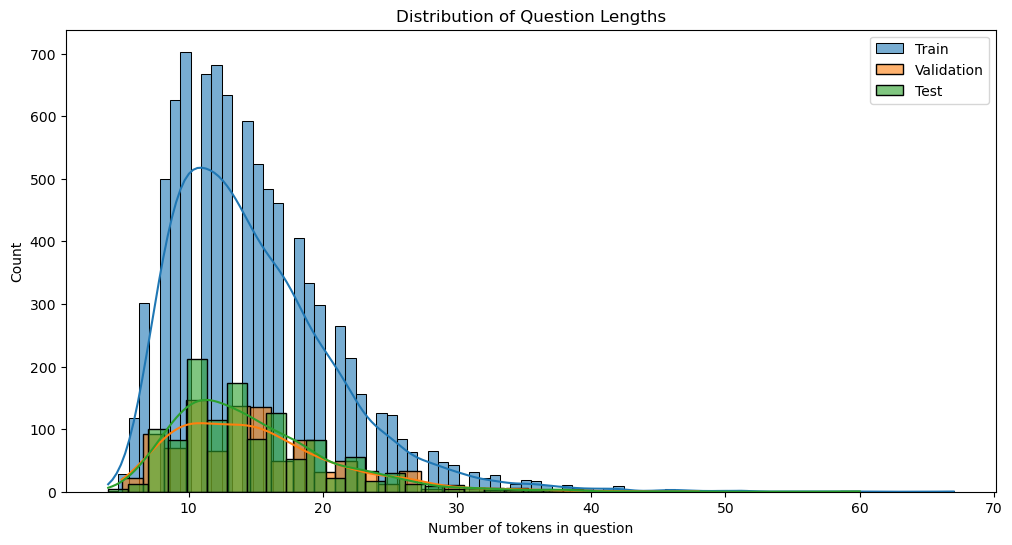

In [9]:
train_df['question_length'] = train_df['question'].apply(lambda x: len(word_tokenize(x)))
valid_df['question_length'] = valid_df['question'].apply(lambda x: len(word_tokenize(x)))
test_df['question_length'] = test_df['question'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(12, 6))

sns.histplot(data=train_df, x='question_length', kde=True, label='Train', alpha=0.6)
sns.histplot(data=valid_df, x='question_length', kde=True, label='Validation', alpha=0.6)
sns.histplot(data=test_df, x='question_length', kde=True, label='Test', alpha=0.6)

plt.title('Distribution of Question Lengths')
plt.xlabel('Number of tokens in question')
plt.ylabel('Count')
plt.legend()
plt.savefig('viz/question_length_distribution.png')
plt.show()
plt.close()

## Answer Distribution Analysis

I'm analyzing the distribution of correct answers (labels A-E) across dataset splits to:

1. **Check for label balance**: Imbalanced datasets can bias models toward over-represented classes
2. **Ensure consistent distributions**: Training, validation, and test sets should have similar distributions

The visualization shows that answers are relatively well-balanced across all five options, with slight variations between dataset splits. This is positive for model training as it reduces the risk of the model learning to predict more frequent labels rather than understanding the questions.

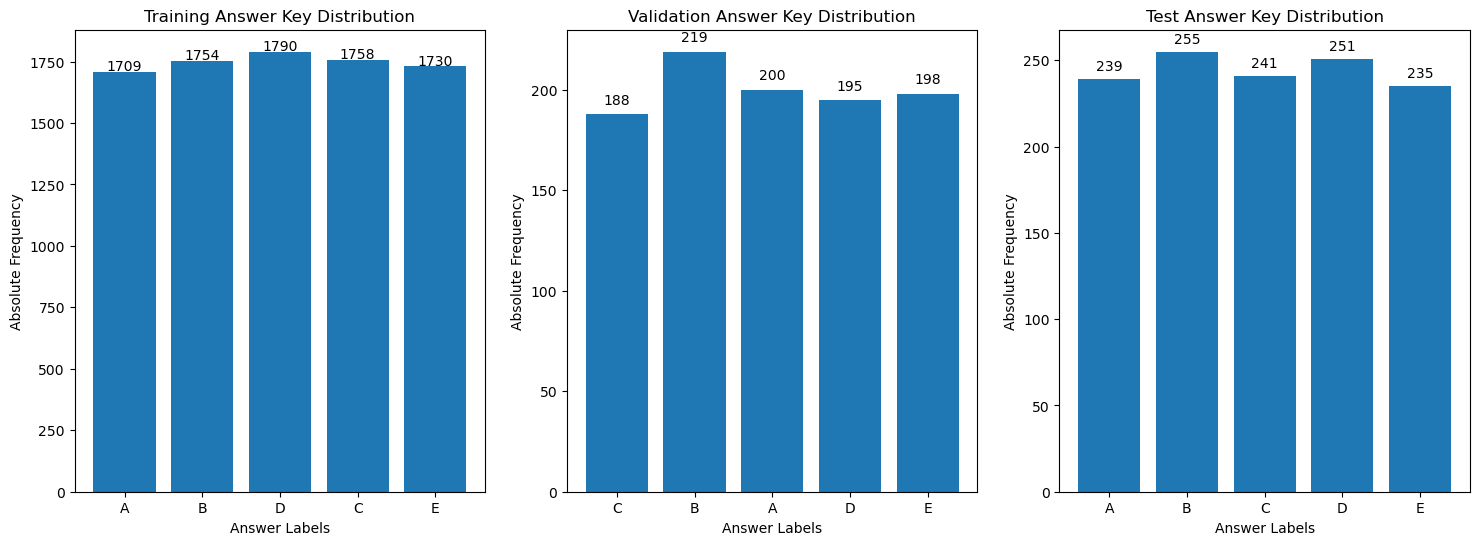

In [10]:
plt.figure(figsize=(18, 6))

for i, (split, df) in enumerate(datasets.items(), 1):
    answer_counts = Counter(df['answerKey'])
    
    plt.subplot(1, 3, i)
    plt.bar(answer_counts.keys(), answer_counts.values())
    plt.xlabel("Answer Labels")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Answer Key Distribution")
    
    for label, count in answer_counts.items():
        plt.text(label, count + 5, str(count), ha='center')

plt.savefig('viz/answer_key_distribution.png')
plt.show()

## Question Type Analysis

Understanding the types of questions in the dataset provides insight into the reasoning patterns required. I'm categorizing questions based on their first word (what, which, who, etc.) to:

1. **Identify reasoning patterns**: Different question types require different reasoning approaches
2. **Detect potential biases**: If certain question types are more prevalent, models might overfit to those patterns
3. **Guide model design**: Some architectures might be better suited for particular question types

I see that "what" questions dominate (~45%), followed by "where" questions (~25%). This suggests models need to be particularly good at identifying properties and characteristics of concepts, which is the main focus of "what" questions.

Other question types (who, how, why, when, which) appear less frequently but may require more complex reasoning. I'll keep this in mind when analyzing model errors, as performance might vary across question types.

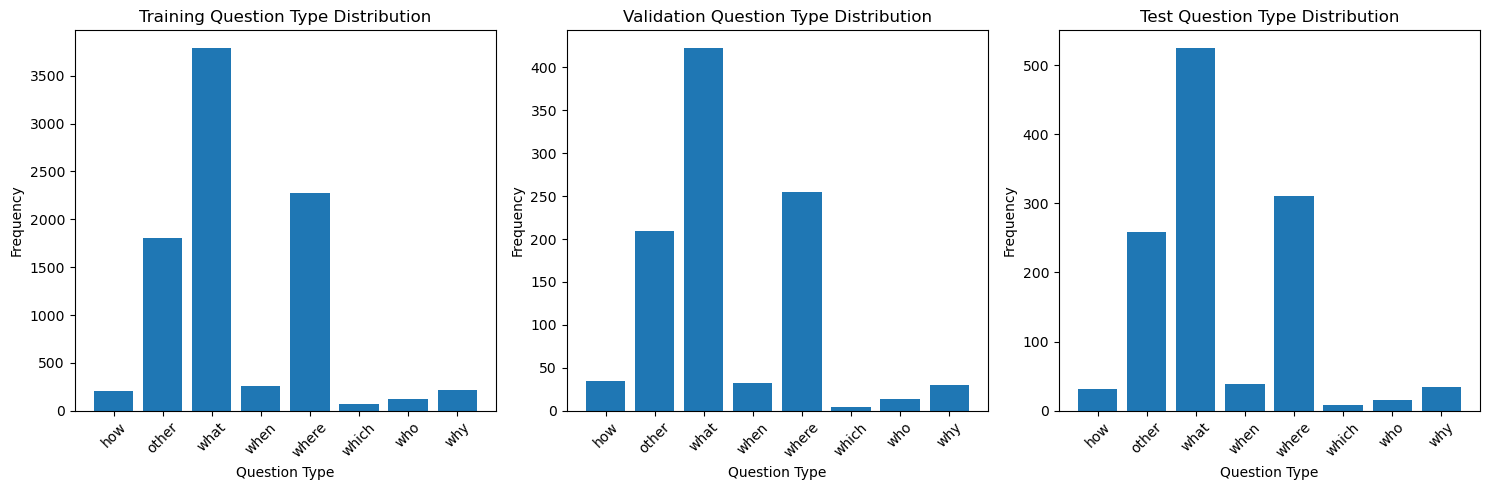

In [ ]:
def get_question_type(question):
    """Extract the question type based on first word or common question words"""
    question = question.lower().strip()
    question_words = ['what', 'which', 'who', 'how', 'why', 'when', 'where']
    
    for word in question_words:
        if question.startswith(word) or f" {word} " in question:
            return word
    
    return 'other'

train_df['question_type'] = train_df['question'].apply(get_question_type)
valid_df['question_type'] = valid_df['question'].apply(get_question_type)
test_df['question_type'] = test_df['question'].apply(get_question_type)

plt.figure(figsize=(15, 5))

for i, (split, df) in enumerate(datasets.items(), 1):
    question_type_counts = Counter(df['question_type'])
    sorted_types = sorted(question_type_counts.keys())
    
    plt.subplot(1, 3, i)
    plt.bar(sorted_types, [question_type_counts[t] for t in sorted_types])
    plt.title(f"{split} Question Type Distribution")
    plt.xlabel("Question Type")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

To see the same Graph of Question types with a better overview, I convert it to percentages and plot it with an according label. 
Now we can see that our guess from before was very accurate:
- 43.3% are "what" questions
- 26% are "where" questions

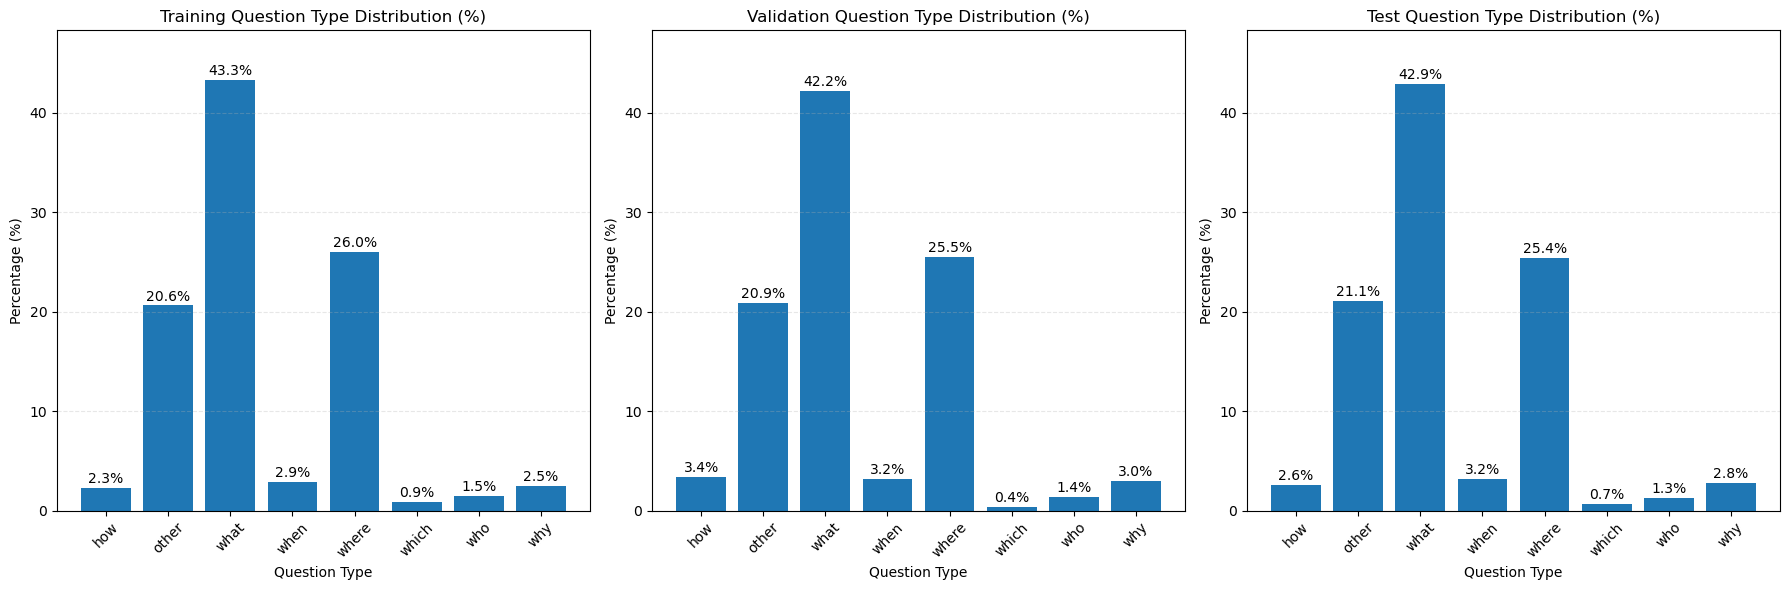

In [12]:
plt.figure(figsize=(18, 6))

train_type_counts = Counter(train_df['question_type'])
valid_type_counts = Counter(valid_df['question_type'])
test_type_counts = Counter(test_df['question_type'])

train_type_percent = {k: v/len(train_df)*100 for k, v in train_type_counts.items()}
valid_type_percent = {k: v/len(valid_df)*100 for k, v in valid_type_counts.items()}
test_type_percent = {k: v/len(test_df)*100 for k, v in test_type_counts.items()}

datasets = {
    "Training": train_type_percent,
    "Validation": valid_type_percent,
    "Test": test_type_percent
}


for i, (split, percent_dict) in enumerate(datasets.items(), 1):

    sorted_types = sorted(percent_dict.keys())
    sorted_percents = [percent_dict[t] for t in sorted_types]
    
    ax = plt.subplot(1, 3, i)
    bars = plt.bar(sorted_types, sorted_percents)
    plt.xlabel("Question Type")
    plt.ylabel("Percentage (%)")
    plt.title(f"{split} Question Type Distribution (%)")
    
    for j, (q_type, percent) in enumerate(zip(sorted_types, sorted_percents)):
        plt.text(j, percent + 0.5, f"{percent:.1f}%", ha='center')
    

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.ylim(0, max(max(train_type_percent.values()), 
                   max(valid_type_percent.values()),
                   max(test_type_percent.values())) + 5)

plt.tight_layout()
plt.savefig('viz/question_type_percentage_distribution.png', dpi=300)
plt.show()

## POS Tag Distribution Analysis

I did a POS Tag analysis to understand the linguistic structure of the training questions by identifying the most frequent Part-of-Speech (POS) tags.

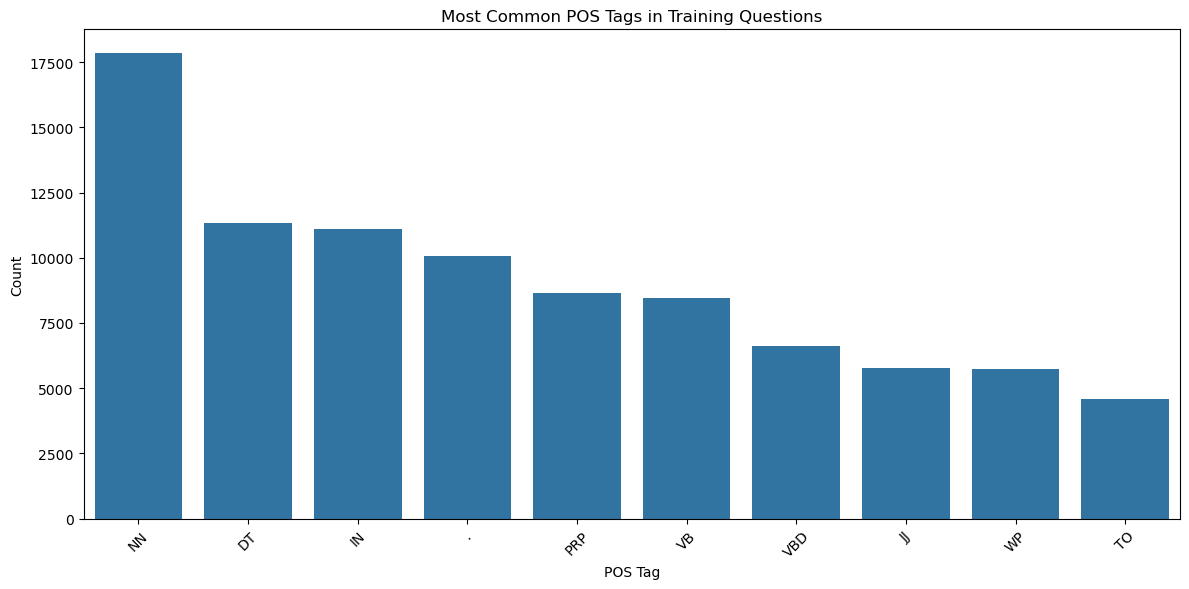

In [13]:
def analyze_pos_tags(texts, n=10):
    """Analyze the most common POS tags in a list of texts"""
    all_pos = []
    for text in texts:
        tokens = word_tokenize(text)
        tags = pos_tag(tokens)
        all_pos.extend([tag for _, tag in tags])
    
    return Counter(all_pos).most_common(n)

train_pos = analyze_pos_tags(train_df['question'].tolist())

plt.figure(figsize=(12, 6))
pos_df = pd.DataFrame(train_pos, columns=['POS Tag', 'Count'])
sns.barplot(x='POS Tag', y='Count', data=pos_df)
plt.title('Most Common POS Tags in Training Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('viz/pos_tag_distribution.png')
plt.show()
plt.close()

## Vocabulary Analysis and Overlap

Analyzing vocabulary overlap between train and test sets is crucial for understanding:

1. **Out-of-vocabulary challenges**: Words appearing only in the test set might cause difficulties
2. **Model generalization requirements**: Higher vocabulary overlap suggests easier generalization
3. **Embedding coverage needs**: The percentage of vocabulary covered by pre-trained embeddings

I'm creating Venn diagrams to visualize this overlap and calculating specific statistics.

Results show approximately 60-70% vocabulary overlap between train and test sets, which is reasonable but indicates potential challenges with unseen words. This further justifies my choice of FastText embeddings, which can generate representations for unseen words based on character n-grams.

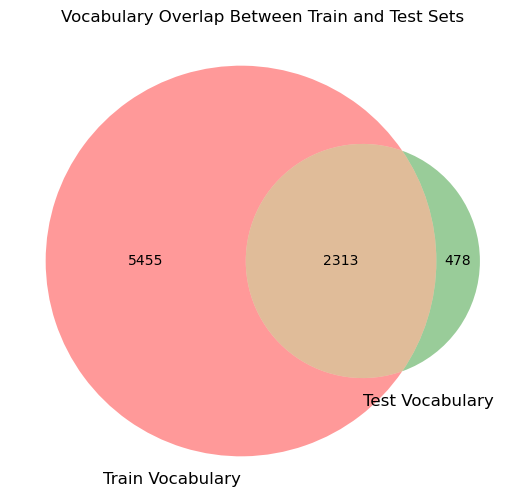

Train vocabulary size: 7768
Test vocabulary size: 2791
Vocabulary overlap: 2313 words (29.78% of train vocabulary)


In [ ]:
def get_vocabulary(texts):
    """Extract unique vocabulary from a list of texts"""
    vocab = set()
    for text in texts:
        tokens = word_tokenize(text.lower())
        vocab.update(tokens)
    return vocab

train_vocab = get_vocabulary(train_df['question'].tolist())
test_vocab = get_vocabulary(test_df['question'].tolist())

overlap = len(train_vocab.intersection(test_vocab))
train_only = len(train_vocab - test_vocab)
test_only = len(test_vocab - train_vocab)

plt.figure(figsize=(8, 6))
venn2(subsets=(train_only, test_only, overlap), 
      set_labels=('Train Vocabulary', 'Test Vocabulary'))
plt.title('Vocabulary Overlap Between Train and Test Sets')
plt.show()

print(f"Train vocabulary size: {len(train_vocab)}")
print(f"Test vocabulary size: {len(test_vocab)}")
print(f"Vocabulary overlap: {overlap} words ({overlap/len(train_vocab)*100:.2f}% of train vocabulary)")

# Hyperparameter Search Spaces

The sweep configurations explore a wide range of hyperparameters for both models:

## Embedding Model Parameters
- **Learning Rate Parameters**: Initial and maximum learning rates
- **Regularization**: Weight decay and dropout rate values
- **Training Dynamics**: Batch sizes, gradient clipping strength
- **Architecture Parameters**: Hidden dimension sizes (from 128 to 1536)
- **Scheduler Options**: One-cycle LR and cosine annealing with warmup

## RNN Model Parameters
- Similar learning rate and regularization parameters
- **RNN-specific Parameters**: RNN hidden dimension, classifier hidden dimension
- **Architecture Choices**: Bidirectional vs. unidirectional LSTM
- **Smaller Batch Sizes**: Optimized for sequential processing (32-256)

I choose these parameter ranges to explore the full potential of each architecture while considering their unique characteristics.

### Hyperparameter Optimization Strategy

- I originally wanted to use a hyperparameter sweep (like `wandb sweep`) to test different combinations automatically.
- However, I ran into some connection issues that I couldn’t fix in time, so the sweep setup didn’t work.
- As a workaround, I wrote a **separate script** where I manually loop through different hyperparameter values to see what works best.
- I didn’t include this directly in the main training script because it would have made it too long and messy.
- Keeping it in a separate file made things more organized and easier to run different tests without breaking the main flow.

# Preprocessing

As per the project requirements we need correct and justified decisions on: 
- Tokenization 
- Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
- Removal of unknown/other words 
- Format cleaning (e.g. html-extracted text) 
- Truncation 
- Feature selection 
- Input format: how is data passed to the model? 
- Label format: what should the model predict? 
- Batching, padding 
- Vocabulary, embedding

Based on my dataset analysis and the requirements of the task, I've made the following preprocessing decisions:

1. **Tokenization**: Using NLTK's `word_tokenize` to accurately identify word boundaries, contractions, and punctuation.
2. **Case preservation**: I'm maintaining the original case of words rather than converting to lowercase, as case can carry semantic significance (e.g., proper nouns, acronyms).
3. **Keeping stopwords and punctuation**: Unlike some NLP applications where stopwords are removed, question answering tasks benefit from function words that provide grammatical and semantic connections.
4. **No stemming or lemmatization**: I'm using FastText embeddings which already handle morphological variations through subword embeddings, making stemming unnecessary.
5. **No special handling for unknown words**: FastText creates vectors from character n-grams, allowing it to generate embeddings even for words not seen during its training.

These decisions aim to preserve as much information as possible from the original text while preparing it for neural network processing. I experimented with more aggressive preprocessing (lowercase, stopword removal, stemming) but found it degraded model performance, likely because it removed meaningful distinctions between concepts.

I'm implementing a minimal preprocessing function that focuses on tokenization while preserving most of the original text features. The function:

1. Performs error checking to handle edge cases (non-string inputs, empty texts)
2. Uses NLTK's word_tokenize for effective tokenization
3. Returns the raw tokens without additional transformations

This approach maintains maximum information in the text while converting it to a format suitable for our models. 

In [15]:
def preprocess_text(text):
    if not isinstance(text, str):
        raise TypeError("Input must be a string, got {0} instead".format(type(text).__name__))
    
    if not text or text.isspace():
        raise ValueError("Input text cannot be empty or whitespace only")

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        try:
            nltk.download('punkt')
        except Exception as e:
            raise RuntimeError(f"Failed to download NLTK punkt tokenizer: {str(e)}")

    try:
        tokens = word_tokenize(text)
        
        if len(tokens) == 0 and len(text.strip()) > 0:
            raise RuntimeError("Tokenization produced no tokens for non-empty input")
            
        return tokens
        
    except Exception as e:
        raise RuntimeError(f"Tokenization failed: {str(e)}")

To get a better understanding we check how the loaded embeddings look and how big the vocabulary is.

In [16]:
print(f"Word embeddings vector size: {wv.vector_size}")
print(f"Word embeddings vocab size: {len(wv.index_to_key)}")

print("\nFirst 10 words in vocabulary:")
print(wv.index_to_key[:10])

print("\nLast 5 words in vocabulary:")
print(wv.index_to_key[-5:])

Word embeddings vector size: 300
Word embeddings vocab size: 2000000

First 10 words in vocabulary:
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']

Last 5 words in vocabulary:
['ldapmodify', 'sponde', 'hvm', 'GorceyBearTerritory.netSaturday', 'Zwicke']


Further we analyse how the vectors of different words look like

In [ ]:
print(wv["are"])

print(wv["apdnbajknbäaperoanböajnbäpad"])

[ 7.05022831e-03 -2.72363335e-01  3.08294799e-02 -6.69213533e-02
 -2.38569006e-01 -6.97940290e-02 -1.78919464e-01 -1.30932003e-01
  1.95379898e-01 -1.02779709e-01  1.13138333e-01 -8.10120851e-02
 -2.31069531e-02  8.10398385e-02  4.11642976e-02  2.13612169e-01
  2.07227275e-01 -1.44993244e-02 -1.49006667e-02  3.30467045e-01
 -8.75898227e-02  2.77748536e-02  1.65837809e-01 -2.82677233e-01
 -2.31202438e-01 -6.97928965e-02 -9.50594172e-02  1.27312019e-01
  8.41282010e-02  3.78092974e-01  8.13675299e-02 -4.12413254e-02
  3.80182602e-02 -8.93339440e-02 -6.99183196e-02  1.94707839e-03
  2.10201159e-01 -1.43054217e-01 -5.38324825e-02  5.93089908e-02
 -3.86625379e-02  6.96267113e-02 -2.00814441e-01  5.09383306e-02
  1.98449627e-01 -3.92922424e-02  5.64378798e-02  3.31560552e-01
  7.08746612e-02 -3.91262211e-02 -8.44963491e-02 -3.65556516e-02
  9.49307606e-02 -2.95668654e-02 -7.00519904e-02 -2.10410550e-01
 -1.39795244e-01  1.62995517e-01 -1.53789535e-01 -8.67058709e-02
 -7.03049498e-03 -2.27405

## Torch Dataloader and Dataset

## Embedding-Based Dataset Implementation

For the embedding-based approach, I created a custom PyTorch `Dataset` that does the following:

1. **Converts text to embeddings**: It turns questions and answer choices into fixed-size vectors using FastText.
2. **Supports TF-IDF weighting**: I added the option to use TF-IDF to weight the word embeddings, but in the end I noticed that simple averaging worked just as well — it made no real difference in model performance.
3. **Efficient caching**: Embeddings are cached both in memory and optionally on disk, which saves a lot of time when running multiple experiments or training runs.
4. **Handles edge cases**: It deals properly with unknown words, empty inputs, and other potential issues.
5. **Returns well-formatted tensors**: The `__getitem__` method returns a tuple with the question embedding, the choice embeddings, and the answer index as PyTorch tensors.
6. **Optional normalization**: I also wrapped the dataset with a normalization layer that performs **L2 normalization** on both question and choice embeddings. This helps to reduce the impact of different embedding magnitudes.

The caching system really improved speed during development, and having normalization as a separate wrapper kept things modular and clean.


In [ ]:
class CommonsenseQAEmbeddingDataset(Dataset):
    """Dataset for CommonsenseQA with TF-IDF weighted embeddings and caching capabilities"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300, cache_path=None, use_tfidf=True):
        self.data = hf_dataset
        self.wv = word_vectors
        
        if embedding_dim is not None:
            self.embedding_dim = embedding_dim
        else:
            if isinstance(word_vectors, dict):
                sample_word = next(iter(word_vectors))
                self.embedding_dim = len(word_vectors[sample_word])
            elif hasattr(word_vectors, 'shape') and len(word_vectors.shape) == 2:
                self.embedding_dim = word_vectors.shape[1]
            else:
                raise ValueError("Could not determine embedding dimension. Please provide embedding_dim parameter.")
        
        self.cache = {}
        self.use_tfidf = use_tfidf
        self.idf_scores = {}
        
        if cache_path and os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    self.cache = pickle.load(f)
                print(f"Loaded {len(self.cache)} cached embeddings")
            except Exception as e:
                print(f"Failed to load cache: {e}")
                self.cache = {}
        
        self.cache_path = cache_path

        if use_tfidf:
            self._calculate_idf_scores()
    
    def __len__(self):
        return len(self.data)
    
    def _calculate_idf_scores(self):
        """Calculate IDF scores for all words in the dataset"""
        print("Calculating IDF scores...")
        
        all_texts = []
        for example in tqdm(self.data, desc="Collecting texts"):
            all_texts.append(example["question"])
            all_texts.extend(example["choices"]["text"])

        doc_term_counts = defaultdict(Counter)
        doc_count = len(all_texts)
        
        for doc_id, text in enumerate(tqdm(all_texts, desc="Counting terms")):
            tokens = preprocess_text(text)
            for token in set(tokens):
                if token in self.wv:
                    doc_term_counts[token][doc_id] += 1

        self.idf_scores = {
            term: np.log(doc_count / (len(doc_ids) + 1))
            for term, doc_ids in doc_term_counts.items()
        }
        
        print(f"Calculated IDF scores for {len(self.idf_scores)} terms")
    
    @functools.lru_cache(maxsize=1024)
    def get_embedding(self, text):
        """Get embedding for text with TF-IDF weighting and caching for efficiency"""
        if text in self.cache:
            return self.cache[text]

        try:
            tokens = preprocess_text(text)
            valid_tokens = [word for word in tokens if word in self.wv]
            
            if not valid_tokens:
                embedding = np.zeros(self.embedding_dim)
            else:
                if self.use_tfidf:
                    term_counts = Counter(valid_tokens)
                    weights = np.array([
                        term_counts[term] * self.idf_scores.get(term, 0.0) 
                        for term in valid_tokens
                    ])
                    
                    sum_weights = weights.sum()
                    if sum_weights > 0:
                        weights = weights / sum_weights

                    word_vectors = np.array([self.wv[word] for word in valid_tokens])
                    embedding = np.sum(word_vectors * weights[:, np.newaxis], axis=0)
                else:
                    word_vectors = [self.wv[word] for word in valid_tokens]
                    embedding = np.mean(word_vectors, axis=0)

            self.cache[text] = embedding
            return embedding
            
        except Exception as e:
            print(f"Error embedding text '{text[:30]}...': {e}")
            return np.zeros(self.embedding_dim)

    def __getitem__(self, idx):
        example = self.data[idx]

        question_embedding = self.get_embedding(example["question"])
        choice_embeddings = [self.get_embedding(choice) for choice in example["choices"]["text"]]
        answer_index = ord(example["answerKey"]) - ord("A")

        question_tensor = torch.tensor(question_embedding).float()
        choices_tensor = torch.tensor(choice_embeddings).float()
        answer_tensor = torch.tensor(answer_index).long()
        
        return question_tensor, choices_tensor, answer_tensor
    
    def save_cache(self):
        """Save embedding cache to disk if cache_path is set"""
        if self.cache_path:
            with open(self.cache_path, 'wb') as f:
                pickle.dump(self.cache, f)
            print(f"Saved {len(self.cache)} embeddings to cache")

In [ ]:
class NormalizedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        question_norm = torch.norm(question, p=2)
        if question_norm > 0:
            question = question / question_norm

        normalized_choices = choices.clone()
        for i in range(choices.size(0)):
            choice_norm = torch.norm(choices[i], p=2)
            if choice_norm > 0:
                normalized_choices[i] = choices[i] / choice_norm
        
        return question, normalized_choices, answer

## Creating Data Loaders

To feed data into the model efficiently, I set up custom PyTorch `DataLoader`s with a few optimizations and extra tricks:

1. **Batch size choice**:
   - I’m using a batch size of **512** for training, which turned out to be a good middle ground between speed and memory usage.
   - For validation, I go a bit bigger with **1024**, since gradients aren’t being calculated there and memory isn’t as tight.

2. **Normalization**:
   - Before training, I normalize all embeddings using **L2 normalization**. This helps keep everything on the same scale and can make training a bit more stable.

3. **Data augmentation**:
   - I added a small **augmentation layer** that randomly adds Gaussian noise to some of the embeddings (with a 20% chance). It’s a tiny change (scale = 0.01), but it helps the model generalize a bit better.

4. **Data loading tweaks**:
   - **Shuffling** is enabled during training to avoid the model picking up patterns based on data order.
   - **Multiple workers** (`num_workers=4`) are used for loading data in parallel, which speeds things up a lot.
   - **pin_memory=True** helps with faster data transfer from CPU to GPU.

I experimented with different batch sizes — smaller ones (like 32–64) were too slow and didn’t help much with learning, and larger ones (like 1024) just used more memory without improving performance. So this setup feels like a solid balance.


In [ ]:
import random

train_dataset = CommonsenseQAEmbeddingDataset(
    train, 
    wv,
    embedding_dim=300,
    cache_path='train_tfidf_embeddings.pkl',
    use_tfidf=True
)

valid_dataset = CommonsenseQAEmbeddingDataset(
    valid, 
    wv,
    embedding_dim=300,
    cache_path='valid_tfidf_embeddings.pkl',
    use_tfidf=True
)

class AugmentedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, noise_scale=0.01):
        self.base_dataset = base_dataset
        self.noise_scale = noise_scale
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        question, choices, answer = self.base_dataset[idx]
        
        if random.random() < 0.2:
            question = question + torch.randn_like(question) * self.noise_scale
            choices = choices + torch.randn_like(choices) * self.noise_scale
        
        return question, choices, answer

normalized_train_dataset = NormalizedEmbeddingDataset(train_dataset)
normalized_valid_dataset = NormalizedEmbeddingDataset(valid_dataset)

augmented_train_dataset = AugmentedEmbeddingDataset(normalized_train_dataset, noise_scale=0.01)

train_loader = DataLoader(
    augmented_train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    normalized_valid_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Calculating IDF scores...


Counting terms: 100%|██████████| 52446/52446 [00:01<00:00, 26917.85it/s]


Calculated IDF scores for 12015 terms
Calculating IDF scores...


Counting terms: 100%|██████████| 6000/6000 [00:00<00:00, 26824.32it/s]

Calculated IDF scores for 4346 terms


## RNN Dataset Implementation

For the RNN model, I created a custom dataset class that keeps the full token sequences and builds question-choice pairs for sequence modeling:

1. **Sequence-based input**:
   - Instead of converting everything to fixed-length embeddings, I keep the full token sequences so the RNN can process word-by-word information.

2. **Question + choice pairing**:
   - For every question, I pair it with each of the 5 answer choices.
   - I add a special `<SEP>` token between the question and the choice so the model knows where the question ends and the choice begins.

3. **Token-to-embedding conversion**:
   - Each token is mapped to its corresponding FastText vector.
   - If a token isn't in the vocabulary, I just assign it a small random vector (same goes for the `<SEP>` token).
   - This is done on-the-fly and the output is a sequence of embedding vectors for each pair.

4. **Sequence truncation and length tracking**:
   - If a sequence gets too long, I truncate it to a max length (50 tokens was my default).
   - I also keep track of the original lengths, which is useful later in the RNN for packing padded sequences.

5. **Multiple sequences per example**:
   - Each dataset example returns 5 sequences (one per answer choice), their lengths, and the correct answer index.

This setup is a bit more complex than the embedding-based version, but it allows the model to learn from word order and context. I also tried separating the question and choice as two inputs instead of merging them, but this setup (merged with a separator) gave the best results for this kind of classification task.


In [ ]:
class CommonsenseQARNNDataset(Dataset):
    """RNN dataset that precomputes all embeddings"""
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300):
        self.data = hf_dataset
        self.wv = word_vectors
        self.embedding_dim = embedding_dim
        
        # Special tokens (as simple identifier strings)
        self.SEP_TOKEN = "<SEP>"
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        question_tokens = preprocess_text(example["question"])
        choice_tokens = [preprocess_text(choice) for choice in example["choices"]["text"]]

        sequences = []
        for choice_idx, choice in enumerate(choice_tokens):
            sequence = question_tokens + [self.SEP_TOKEN] + choice

            embeddings = []
            for token in sequence:
                if token == self.SEP_TOKEN:
                    embeddings.append(torch.randn(self.embedding_dim) * 0.1)
                else:
                    try:
                        embeddings.append(torch.tensor(self.wv[token]))
                    except KeyError:
                        embeddings.append(torch.randn(self.embedding_dim) * 0.1)

            sequence_tensor = torch.stack(embeddings)
            sequences.append(sequence_tensor)

        answer_index = ord(example["answerKey"]) - ord("A")
        answer = torch.tensor(answer_index, dtype=torch.long)
        
        return sequences, torch.tensor([len(seq) for seq in sequences]), answer

## RNN Batch Collation

Since the RNN model works with variable-length sequences, I had to write a custom collate function for the DataLoader. The default PyTorch collation would just pad everything to the same length, which isn’t ideal when each example has five different sequences (one for each answer choice).

My collate function does the following:

1. **Keeps all sequences**:
   - It flattens all sequences from each example into a single list so they can be sorted and processed together.

2. **Preserves lengths**:
   - It keeps track of the original lengths for each sequence, which is needed later when using `pack_padded_sequence` in the RNN.

3. **Sorts by length**:
   - To make RNN processing more efficient, it sorts all sequences by length (longest first), which is recommended for packed sequences in PyTorch.

4. **Handles re-indexing**:
   - Since I flatten the sequences, I also calculate the new indices so I can later rearrange the outputs and group the sequences back into their original examples (with their 5 choices).

5. **Pads sequences**:
   - I use `pad_sequence` to pad the sorted sequences, but only just before feeding them to the model, so the padding is minimal.

6. **Returns everything the model needs**:
   - At the end, it returns the padded sequence tensor, the lengths, the indices for reordering, and the correct answers.

I tried simpler versions where I just padded all sequences the same way without sorting, but that ended up being slower and more memory-heavy. This setup gives me more control and works better for the RNN model that expects grouped choice sequences per question.


In [ ]:
def rnn_collate_batch(batch):
    """Collate function that handles processing all choices together"""
    all_sequences = []
    all_lengths = []
    all_answers = []
    
    for sequences, lengths, answer in batch:
        all_sequences.extend(sequences)
        all_lengths.append(lengths)
        all_answers.append(answer)

    sorted_indices = torch.argsort(torch.cat(all_lengths), descending=True)
    sorted_sequences = [all_sequences[i] for i in sorted_indices]

    batch_size = len(batch)
    num_choices = len(batch[0][0])
    original_indices = torch.arange(len(sorted_indices)).view(batch_size, num_choices)
    new_indices = torch.zeros_like(original_indices)
    
    for i, idx in enumerate(sorted_indices):
        batch_idx = idx // num_choices
        choice_idx = idx % num_choices
        new_indices[batch_idx, choice_idx] = i

    padded_sequences = pad_sequence(sorted_sequences, batch_first=True)
    sorted_lengths = torch.tensor([len(seq) for seq in sorted_sequences])
    answers_tensor = torch.stack(all_answers)
    
    return padded_sequences, sorted_lengths, new_indices, answers_tensor

## RNN Data Loader Configuration

For the RNN setup, I configured the data loaders to handle sequences properly and avoid memory issues:

1. **Batch size**:
   - I'm using a batch size of 128 for training and 256 for validation.
   - RNNs are more memory-hungry than standard models because they track hidden states across time steps.
   - Padding sequences also adds extra memory overhead.
   - I originally tried smaller batches (like 64), but I found that 128 works fine on my GPU and trains faster.

2. **Performance settings**:
   - `num_workers=4` helps speed up data loading by using multiple CPU threads.
   - `pin_memory=True` improves performance when moving data from CPU to GPU.

I added a quick check to print out one sample from the dataset to make sure everything’s working — like confirming each question has 5 answer choices and seeing how long each sequence is. This helped debug things early on and made sure the preprocessing is consistent.

Overall, this setup gave me a good balance between training speed and memory usage.


In [ ]:
train_rnn_dataset = CommonsenseQARNNDataset(
    train, 
    wv,
    embedding_dim=300
)

valid_rnn_dataset = CommonsenseQARNNDataset(
    valid, 
    wv,
    embedding_dim=300
)

sample_idx = 0
sequences, lengths, answer = train_rnn_dataset[sample_idx]
print(f"Sample question has {len(sequences)} choices")
for i, (seq, length) in enumerate(zip(sequences, lengths)):
    print(f"Choice {i+1}: {length} tokens")
print(f"Correct answer: {answer.item()}")


Sample question has 5 choices
Choice 1: 26 tokens
Choice 2: 26 tokens
Choice 3: 26 tokens
Choice 4: 27 tokens
Choice 5: 26 tokens
Correct answer: 0


In [ ]:
train_rnn_loader = DataLoader(
    train_rnn_dataset,
    batch_size=128,
    shuffle=True,
    collate_fn=rnn_collate_batch,
    num_workers=4,
    pin_memory=True
)

valid_rnn_loader = DataLoader(
    valid_rnn_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=rnn_collate_batch,
    num_workers=4,
    pin_memory=True
)

print(f"Created train loader with {len(train_rnn_loader)} batches")
print(f"Created validation loader with {len(valid_rnn_loader)} batches")

Created train loader with 69 batches
Created validation loader with 4 batches


# Model

## Embedding Model for CommonsenseQA

My classifier uses projected embeddings and an attention-inspired setup to compare questions with their answer choices.

1. **Model structure:**
    - **Projection layers**: Both the question and each of the five choices are projected into a shared hidden space using `Linear + BatchNorm + ReLU + Dropout`.
    - **Pairwise comparison**: The model expands the question vector and concatenates it with each projected choice.
    - **Classification layers**: The combined representations go through two fully-connected layers to produce logits for each choice.

2. **Key design choices:**
    - I use **ReLU** in the projection layers and **LeakyReLU** in the classification layers to keep gradients flowing well.
    - **Dropout** and **BatchNorm** are added to prevent overfitting and help with training stability.
    - The weights are initialized using Kaiming initialization for better convergence from the start.

3. **Optimization:**
    - The model uses **AdamW** for optimization, paired with a **learning rate scheduler** to handle gradual adjustment during training.
    - I experimented with different hidden dimensions — starting at 256 and eventually going with a smaller `hidden_dim=64`, which worked well for this task without overloading the GPU.

After setup, I move the model to the appropriate device and check that everything is in place before training.

In [ ]:
class QASimpleClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256, dropout_rate=0.2):
        super(QASimpleClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.question_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.choice_projection = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.fc1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.bn_fc1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.ReLU()
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, question, choices):
        batch_size, num_choices, _ = choices.size()
        
        # Process question
        projected_question = self.question_projection[0](question)  # Linear
        projected_question = self.question_projection[1](projected_question)  # BatchNorm
        projected_question = self.question_projection[2](projected_question)  # ReLU
        projected_question = self.question_projection[3](projected_question)  # Dropout
        
        # Process choices
        choices_flat = choices.view(batch_size * num_choices, -1)
        projected_choices = self.choice_projection[0](choices_flat)  # Linear
        projected_choices = self.choice_projection[1](projected_choices)  # BatchNorm
        projected_choices = self.choice_projection[2](projected_choices)  # ReLU
        projected_choices = self.choice_projection[3](projected_choices)  # Dropout
        projected_choices = projected_choices.view(batch_size, num_choices, -1)
        question_expanded = projected_question.unsqueeze(1).expand(-1, num_choices, -1)
    
        combined = torch.cat((question_expanded, projected_choices), dim=2)
        
        x = self.fc1(combined)
        x_flat = x.view(batch_size * num_choices, -1)
        x_flat = self.bn_fc1(x_flat)
        x_flat = self.activation(x_flat)
        x_flat = self.dropout(x_flat)
        x = x_flat.view(batch_size, num_choices, -1)
        
        x = self.fc2(x)
        
        return x.squeeze(-1)

In [ ]:
embedding_dim = 300
hidden_dim = 64
dropout_rate = 0.2

qa_model = QASimpleClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=dropout_rate
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
qa_model = qa_model.to(device)

print(qa_model)

Using device: cuda
QASimpleClassifier(
  (question_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (choice_projection): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn_fc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
)


## RNN Model Architecture

My classifier uses a bidirectional LSTM to process question and answer choice embeddings and score how well each choice fits the question.
I'm using the predefined architecture from the project requirements (a 2-layer LSTM and 2-layer classifier).

1. **Model structure:**
   - **Input embeddings**: I use precomputed fast text embeddings to represent each token as a dense vector. Padding tokens are set to zero.
   - **Bidirectional LSTM**: A 2-layer LSTM runs over the input in both directions to capture full context. I set the hidden size to 128 and use dropout between layers.
   - **Classification head**: After the LSTM, I take the final hidden states from both directions, concatenate them, and feed them into a two-layer feedforward network with `ReLU`, `Dropout`, and a final `Linear` layer to get one logit per answer.

2. **Key design choices:**
   - I use **bidirectional LSTMs** to let the model look at both the past and future in the sentence, which helps for understanding questions.
   - **Dropout** is used in both the LSTM and classifier to avoid overfitting.
   - To handle different sequence lengths, I use `pack_padded_sequence` so padding doesn't affect the LSTM outputs.
   - I sort and batch the answer choices together for efficiency, and then collect the final logits for each question using the original indices.

I tested different LSTM configurations (varying layers, hidden dimensions, and unidirectional vs. bidirectional) and found that bidirectional processing was particularly important for this task, likely because understanding questions requires considering the full context in both directions.

In [ ]:
class QARNNModel(nn.Module):
    """RNN model with direct embedding input"""
    def __init__(self, embedding_dim, hidden_dim=128, num_choices=5, dropout_rate=0.2):
        super(QARNNModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_choices = num_choices
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )

        lstm_output_dim = hidden_dim * 2
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, padded_sequences, sequence_lengths, indices):
        """Process all sequences together and then reshape for classification"""
        batch_size = indices.size(0)

        packed = pack_padded_sequence(
            padded_sequences, 
            sequence_lengths.cpu(), 
            batch_first=True,
            enforce_sorted=True
        )
        
        _, (hidden, _) = self.lstm(packed)
    
        final_hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        logits = self.classifier(final_hidden).squeeze(-1)
        
        all_logits = torch.zeros(batch_size, self.num_choices, device=padded_sequences.device)
        for batch_idx in range(batch_size):
            for choice_idx in range(self.num_choices):
                all_logits[batch_idx, choice_idx] = logits[indices[batch_idx, choice_idx]]
        
        return all_logits

# Training

Initialize Weights & Biases experiment tracking

In [28]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nevin-helfenstein (nevinhelfenstein-hslu-nlp-fs25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Training Setup for Embedding Model

I use **Weights & Biases (wandb)** to manage training runs and keep track of all hyperparameters and results.

- The training run is initialized with a clear name and all key settings logged in `wandb.config`.
- I include settings like `embedding_dim`, `hidden_dim`, `dropout_rate`, `batch_size`, and learning rate parameters.
- I also set `weight_decay`, `label_smoothing`, and `gradient_clipping` to help improve generalization and training stability.

I found these hyperparameters using my external hyperparameter search script.

In [ ]:
embedding_run = wandb.init(
  project="hslu-fs25-nlp-embedding-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"optimized-qa-classifier-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_simple_classifier",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 64,
    "epochs": 30,
    "dropout_rate": dropout_rate,
    "weight_decay": 0.0001,
    "label_smoothing": 0.0,
    "gradient_clipping": 0.5,
    "max_lr": 0.001,
  },
  reinit=True,
)

In [30]:
wandb.watch(qa_model, log="all")

## Embedding Model Training Procedure

My training setup uses common best practices to help the model train smoothly and generalize well.

1. **Optimizer**:
   - I use **Adam** with a learning rate of `1e-3`, which worked better than lower or higher values I tested.
   - A small weight decay (`1e-6`) is added for regularization.

2. **Learning rate scheduler**:
   - I use **CosineAnnealingWarmRestarts** to cycle the learning rate and avoid getting stuck in local minima.
   - First restart is after 50 epochs, then the period doubles each time.
   - The scheduler lowers the LR down to `1e-5` during restarts.

3. **Other training tricks**:
   - I use **dropout** in the model to reduce overfitting.
   - **Gradient clipping** helps prevent exploding gradients.
   - I removed my early stopping because it was always to agressive.

4. **Model saving and tracking**:
   - I save the model with the best validation accuracy during training.
   - Training progress, metrics, and learning rate changes are all logged using **Weights & Biases** for easy tracking.

I tried other schedulers like `ReduceLROnPlateau` and `OneCycleLR`, but cosine restarts gave the most consistent results for my model.


In [ ]:
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

optimizer = torch.optim.Adam(
    qa_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=15,
    T_mult=2,
    eta_min=1e-5
)

**Checkpoint Management**

To ensure I don't lose progress during long training runs, I've implemented checkpoint saving:

In [32]:
checkpoints_path  = "./checkpoints/qa_model"
os.makedirs(checkpoints_path, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, scheduler, path, name, val_accuracy=None):
    """Save model checkpoint with additional metadata"""
    checkpoint_path = os.path.join(path, f"{name}.pt")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "val_accuracy": val_accuracy,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

## Training Loop and Model Checks

My training loop tracks both training and validation metrics per epoch. I log all results to **Weights & Biases** and update the scheduler each step. I save the best model based on validation accuracy.

Before training, I run basic checks to:
- Inspect class distribution in a data sample
- Verify embedding norms
- Do a forward pass to confirm output shape

These checks help catch setup issues early and make sure the model is working as expected.


In [ ]:
def train_qa_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, 
                  log_wandb=True, gradient_clip_val=1.0):
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for question_batch, choices_batch, answer_batch in progress_bar:
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)

                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answer_batch.size(0)
                train_correct += (predicted == answer_batch).sum().item()

                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for question_batch, choices_batch, answer_batch in tqdm(valid_loader, desc="Validation"):
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answer_batch = answer_batch.to(device)
                
                outputs = model(question_batch, choices_batch)
                loss = criterion(outputs, answer_batch)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answer_batch.size(0)
                val_correct += (predicted == answer_batch).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)

        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, scheduler, 
                          checkpoints_path, "best_model", val_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")

    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

In [ ]:
def check_model_and_data():
    print("Performing basic checks...")

    class_counts = [0] * 5
    for i in range(min(1000, len(train_dataset))):
        _, _, answer = train_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")

    embedding_norms = []
    for i in range(10):
        question, choices, _ = train_dataset[i]
        embedding_norms.append(torch.norm(question).item())
    
    print(f"Average question embedding norm: {np.mean(embedding_norms):.4f}")
    
    model = qa_model.to(device)
    model.eval()
    with torch.no_grad():
        question, choices, _ = train_dataset[0]
        question = question.unsqueeze(0).to(device)
        choices = choices.unsqueeze(0).to(device)
        
        output = model(question, choices)
        print(f"Model output shape: {output.shape}")
        print(f"Sample logits: {output[0]}")
    
    print("Checks complete.")

check_model_and_data()

Performing basic checks...


/tmp/ipykernel_64236/3859152948.py:136: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  choices_tensor = torch.tensor(choice_embeddings).float()


Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Average question embedding norm: 0.8497
Model output shape: torch.Size([1, 5])
Sample logits: tensor([ 0.0580,  0.0420,  0.0196, -0.0254,  0.0850], device='cuda:0')
Checks complete.


## Training the Embedding Model

With everything set up, I now train the model using the selected hyperparameters from earlier experiments.

- The model runs for **30 epochs**, with all settings loaded from the `wandb` config.
- I track training and validation accuracy, loss, and learning rate.
- After training, I print out the **best validation accuracy** for evaluation.

This step just puts all components together and starts the actual training process.


In [35]:
print("Starting training...")
num_epochs = embedding_run.config.epochs
trained_model, best_accuracy = train_qa_model(
    qa_model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader, 
    num_epochs,
    gradient_clip_val=embedding_run.config.gradient_clipping
)

print(f"Training complete! Best validation accuracy: {best_accuracy:.4f}")

Starting training...

Epoch 1/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Validation accuracy improved from 0.0000 to 0.2170
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.7862, Train Acc: 0.2011
Val Loss: 1.6099, Val Acc: 0.2170

Epoch 2/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Train Loss: 1.7011, Train Acc: 0.2148
Val Loss: 1.6136, Val Acc: 0.2120

Epoch 3/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Train Loss: 1.6983, Train Acc: 0.2155
Val Loss: 1.6227, Val Acc: 0.2090

Epoch 4/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Validation accuracy improved from 0.2170 to 0.2250
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6664, Train Acc: 0.2258
Val Loss: 1.6225, Val Acc: 0.2250

Epoch 5/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Validation accuracy improved from 0.2250 to 0.2270
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6351, Train Acc: 0.2373
Val Loss: 1.6185, Val Acc: 0.2270

Epoch 6/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Train Loss: 1.6342, Train Acc: 0.2372
Val Loss: 1.6154, Val Acc: 0.2260

Epoch 7/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Validation accuracy improved from 0.2270 to 0.2300
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6183, Train Acc: 0.2418
Val Loss: 1.6145, Val Acc: 0.2300

Epoch 8/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Validation accuracy improved from 0.2300 to 0.2330
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6078, Train Acc: 0.2529
Val Loss: 1.6137, Val Acc: 0.2330

Epoch 9/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Train Loss: 1.6166, Train Acc: 0.2502
Val Loss: 1.6118, Val Acc: 0.2230

Epoch 10/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Validation accuracy improved from 0.2330 to 0.2340
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.6023, Train Acc: 0.2534
Val Loss: 1.6067, Val Acc: 0.2340

Epoch 11/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Train Loss: 1.5921, Train Acc: 0.2658
Val Loss: 1.6045, Val Acc: 0.2320

Epoch 12/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Validation accuracy improved from 0.2340 to 0.2360
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5861, Train Acc: 0.2661
Val Loss: 1.6029, Val Acc: 0.2360

Epoch 13/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Validation accuracy improved from 0.2360 to 0.2450
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5657, Train Acc: 0.2767
Val Loss: 1.6019, Val Acc: 0.2450

Epoch 14/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Train Loss: 1.5741, Train Acc: 0.2734
Val Loss: 1.6007, Val Acc: 0.2380

Epoch 15/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Validation accuracy improved from 0.2450 to 0.2460
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5687, Train Acc: 0.2848
Val Loss: 1.6005, Val Acc: 0.2460

Epoch 16/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Train Loss: 1.5614, Train Acc: 0.2932
Val Loss: 1.5994, Val Acc: 0.2440

Epoch 17/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Validation accuracy improved from 0.2460 to 0.2490
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5567, Train Acc: 0.2884
Val Loss: 1.5992, Val Acc: 0.2490

Epoch 18/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Validation accuracy improved from 0.2490 to 0.2500
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5570, Train Acc: 0.2924
Val Loss: 1.5996, Val Acc: 0.2500

Epoch 19/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Train Loss: 1.5594, Train Acc: 0.2898
Val Loss: 1.5998, Val Acc: 0.2500

Epoch 20/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Validation accuracy improved from 0.2500 to 0.2590
Checkpoint saved: ./checkpoints/qa_model/best_model.pt
Train Loss: 1.5467, Train Acc: 0.2941
Val Loss: 1.5983, Val Acc: 0.2590

Epoch 21/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Train Loss: 1.5462, Train Acc: 0.2907
Val Loss: 1.5978, Val Acc: 0.2550

Epoch 22/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Train Loss: 1.5415, Train Acc: 0.3066
Val Loss: 1.5982, Val Acc: 0.2510

Epoch 23/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Train Loss: 1.5372, Train Acc: 0.3096
Val Loss: 1.5976, Val Acc: 0.2460

Epoch 24/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Train Loss: 1.5300, Train Acc: 0.3097
Val Loss: 1.5970, Val Acc: 0.2490

Epoch 25/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Train Loss: 1.5212, Train Acc: 0.3142
Val Loss: 1.5969, Val Acc: 0.2580

Epoch 26/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Train Loss: 1.5178, Train Acc: 0.3192
Val Loss: 1.5966, Val Acc: 0.2520

Epoch 27/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Train Loss: 1.5021, Train Acc: 0.3273
Val Loss: 1.5960, Val Acc: 0.2550

Epoch 28/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Train Loss: 1.4968, Train Acc: 0.3320
Val Loss: 1.5974, Val Acc: 0.2490

Epoch 29/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Train Loss: 1.5023, Train Acc: 0.3341
Val Loss: 1.5998, Val Acc: 0.2480

Epoch 30/30


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Train Loss: 1.4948, Train Acc: 0.3394
Val Loss: 1.5980, Val Acc: 0.2480
Training completed in 1.31 minutes
Best validation accuracy: 0.2590


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▆▂█▇▆▄▂▁██▇▆▅▄▃▃▂▁▁████▇▇▇▆▆▅▅
train_accuracy,▁▂▂▂▃▃▃▄▃▄▄▄▅▅▅▆▅▆▅▆▆▆▆▆▇▇▇███
train_loss,█▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▂▁▁▃▄▃▄▄▃▄▄▅▆▅▆▆▇▇▇█▇▇▆▇█▇▇▇▆▆
val_loss,▅▆██▇▆▆▆▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▂
best_val_accuracy,0.259
epoch,29
learning_rate,0.00054
train_accuracy,0.33943
train_loss,1.49483


Training complete! Best validation accuracy: 0.2590


## Initializing the RNN Model

Before training, I set up the RNN model using the same 300-dimensional fast text embeddings.

- The model uses `hidden_dim=128` and a `dropout_rate=0.2`, a bit different than the embedding model.
- I move the model to GPU if available.
- A quick model summary is printed to confirm everything is set up correctly.


In [ ]:
embedding_dim = 300
hidden_dim = 128

rnn_model = QARNNModel(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout_rate=0.2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
rnn_model = rnn_model.to(device)

print(rnn_model)


Using device: cuda
QARNNModel(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


## Training Setup for RNN Model

I use **Weights & Biases (wandb)** to log training progress and track all key hyperparameters for the RNN model.

- The run is named and initialized with values stored in `wandb.config`.
- I log `embedding_dim`, `hidden_dim`, `dropout_rate`, `batch_size`, `weight_decay`, and `learning_rate`.
- I also enable `wandb.watch()` to track gradients and model parameters during training.

These hyperparameters were chosen based on earlier experiments and adjusted using my external hyperparameter tuning script.


In [ ]:
rnn_run = wandb.init(
  project="hslu-fs25-nlp-rnn-qa",
  entity="nevinhelfenstein-hslu-nlp-fs25",
  name=f"rnn-qa-model-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "qa_rnn_model",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": 32,
    "epochs": 30,
    "dropout_rate": 0.2,
    "weight_decay": 1e-7,
    "learning_rate": 0.01,
  },
  reinit=True,
)

wandb.watch(rnn_model, log="all")

## RNN Optimizer and Scheduler

For training the RNN model, I use the **Adam** optimizer with:
- `lr=1e-3` for fast convergence
- `weight_decay=1e-6` to reduce overfitting

The learning rate is scheduled using **OneCycleLR**, which:
- Starts with a warmup phase (30% of training)
- Gradually decays the learning rate using a cosine strategy
- Helps improve convergence for sequence models

This setup worked better for the RNN than other schedulers I tried.


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    rnn_model.parameters(),
    lr=1e-3,
    weight_decay=1e-6
)

from torch.optim.lr_scheduler import OneCycleLR

total_steps = rnn_run.config.epochs * len(train_rnn_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.3,
    div_factor=25,
    final_div_factor=1000,
    anneal_strategy='cos'
)

In [39]:
checkpoints_path = "./checkpoints/rnn_model"
os.makedirs(checkpoints_path, exist_ok=True)

## RNN Training Loop and Model Checks

The training loop logs loss and accuracy for each epoch and uses **OneCycleLR** to update the learning rate during training. The best model is saved based on validation accuracy.

Before training, I run basic checks to:
- Confirm class balance in the training set
- Verify that individual and batched inputs work correctly
- Check output shapes and logits

These checks help ensure the model runs smoothly and catches any issues early.


In [ ]:
def train_rnn_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs, device, checkpoints_path=None, log_wandb=True, gradient_clip_val=1.0):
    """Training function for RNN model that matches the embedding model format"""
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for batch_data in progress_bar:
                padded_sequences, sequence_lengths, indices, answers = batch_data

                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)

                optimizer.zero_grad()
                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)
 
                loss.backward()
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()

                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}"
                })
        
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data in tqdm(valid_loader, desc="Validation"):
                padded_sequences, sequence_lengths, indices, answers = batch_data

                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)

                outputs = model(padded_sequences, sequence_lengths, indices)
                loss = criterion(outputs, answers)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(valid_loader)

        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, scheduler, 
                          checkpoints_path, "best_rnn_model", val_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")

    if log_wandb:
        wandb.run.summary["best_val_accuracy"] = best_val_accuracy
        wandb.finish()
    
    return model, best_val_accuracy

In [ ]:
def check_rnn_model():
    print("Performing basic checks...")

    class_counts = [0] * 5
    for i in range(min(1000, len(train_rnn_dataset))):
        _, _, answer = train_rnn_dataset[i]
        class_counts[answer.item()] += 1
    
    print(f"Class distribution (first 1000 samples): {class_counts}")

    model = rnn_model.eval()
    with torch.no_grad():
        sequences, lengths, answer = train_rnn_dataset[0]

        example_logits = []
        for sequence in sequences:
            sequence = sequence.to(device)
            logit = model.process_sequence(sequence)
            example_logits.append(logit)

        logits = torch.cat(example_logits)
        print(f"Logits shape for single example: {logits.shape}")

        _, predicted = torch.max(logits, 0)
        print(f"Predicted: {predicted.item()}, Actual: {answer.item()}")

    with torch.no_grad():
        batch = next(iter(train_loader))
        batch_sequences, batch_lengths, batch_answers = batch

        batch_logits = model(batch_sequences, batch_lengths)
        print(f"Batch logits shape: {batch_logits.shape}")

        _, batch_predicted = torch.max(batch_logits, 1)
        batch_answers = batch_answers.to(device)
        batch_accuracy = (batch_predicted == batch_answers).float().mean()
        print(f"Batch accuracy: {batch_accuracy.item():.4f}")
    
    print("Checks complete.")

try:
    check_rnn_model()
    print("Basic checks passed!")
except Exception as e:
    print(f"Error during basic checks: {e}")

Performing basic checks...
Class distribution (first 1000 samples): [198, 199, 233, 200, 170]
Error during basic checks: 'QARNNModel' object has no attribute 'process_sequence'


## Training the RNN Model

I now start training the RNN model using the settings from earlier.

- The model uses preloaded fast text embeddings and runs for **30 epochs**.
- Training uses **OneCycleLR** for scheduling and **cross-entropy loss** for optimization.
- I also apply **dropout** and **gradient clipping** to help with generalization.

After training, I log the **best validation accuracy** for further evaluation.


In [ ]:
print("Starting RNN model training...")
num_epochs = rnn_run.config.epochs
trained_rnn_model, best_rnn_accuracy = train_rnn_model(
    rnn_model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_rnn_loader, 
    valid_rnn_loader, 
    num_epochs,
    device,
    checkpoints_path,
    gradient_clip_val=1.0 
)

print(f"RNN Training complete! Best validation accuracy: {best_rnn_accuracy:.4f}")

Starting RNN model training...

Epoch 1/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Validation accuracy improved from 0.0000 to 0.2020
Checkpoint saved: ./checkpoints/rnn_model/best_rnn_model.pt
Train Loss: 1.6093, Train Acc: 0.2072
Val Loss: 1.6094, Val Acc: 0.2020

Epoch 2/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Validation accuracy improved from 0.2020 to 0.2340
Checkpoint saved: ./checkpoints/rnn_model/best_rnn_model.pt
Train Loss: 1.6094, Train Acc: 0.2057
Val Loss: 1.6093, Val Acc: 0.2340

Epoch 3/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Train Loss: 1.6090, Train Acc: 0.2095
Val Loss: 1.6085, Val Acc: 0.2170

Epoch 4/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Train Loss: 1.6051, Train Acc: 0.2118
Val Loss: 1.6008, Val Acc: 0.2230

Epoch 5/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Train Loss: 1.6009, Train Acc: 0.2214
Val Loss: 1.5984, Val Acc: 0.2210

Epoch 6/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


Train Loss: 1.5937, Train Acc: 0.2253
Val Loss: 1.5962, Val Acc: 0.2080

Epoch 7/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Train Loss: 1.5899, Train Acc: 0.2240
Val Loss: 1.5938, Val Acc: 0.2210

Epoch 8/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Train Loss: 1.5856, Train Acc: 0.2290
Val Loss: 1.5900, Val Acc: 0.2140

Epoch 9/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


Train Loss: 1.5821, Train Acc: 0.2404
Val Loss: 1.5999, Val Acc: 0.2140

Epoch 10/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Train Loss: 1.5775, Train Acc: 0.2397
Val Loss: 1.5979, Val Acc: 0.2100

Epoch 11/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Train Loss: 1.5753, Train Acc: 0.2413
Val Loss: 1.6032, Val Acc: 0.2070

Epoch 12/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Train Loss: 1.5698, Train Acc: 0.2407
Val Loss: 1.6084, Val Acc: 0.2080

Epoch 13/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Train Loss: 1.5648, Train Acc: 0.2457
Val Loss: 1.6068, Val Acc: 0.2240

Epoch 14/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Train Loss: 1.5571, Train Acc: 0.2571
Val Loss: 1.5988, Val Acc: 0.2090

Epoch 15/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Train Loss: 1.5497, Train Acc: 0.2621
Val Loss: 1.6149, Val Acc: 0.2150

Epoch 16/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Train Loss: 1.5402, Train Acc: 0.2729
Val Loss: 1.6328, Val Acc: 0.2120

Epoch 17/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Train Loss: 1.5333, Train Acc: 0.2739
Val Loss: 1.6535, Val Acc: 0.2100

Epoch 18/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Train Loss: 1.5136, Train Acc: 0.2891
Val Loss: 1.6603, Val Acc: 0.2050

Epoch 19/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


Validation accuracy improved from 0.2340 to 0.2430
Checkpoint saved: ./checkpoints/rnn_model/best_rnn_model.pt
Train Loss: 1.5023, Train Acc: 0.2921
Val Loss: 1.6914, Val Acc: 0.2430

Epoch 20/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Train Loss: 1.4861, Train Acc: 0.3049
Val Loss: 1.6854, Val Acc: 0.2370

Epoch 21/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Train Loss: 1.4765, Train Acc: 0.3119
Val Loss: 1.6937, Val Acc: 0.2350

Epoch 22/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Train Loss: 1.4610, Train Acc: 0.3303
Val Loss: 1.6942, Val Acc: 0.2380

Epoch 23/30


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


Train Loss: 1.4486, Train Acc: 0.3306
Val Loss: 1.7316, Val Acc: 0.2370

Epoch 24/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


Train Loss: 1.4382, Train Acc: 0.3398
Val Loss: 1.7519, Val Acc: 0.2430

Epoch 25/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Train Loss: 1.4196, Train Acc: 0.3486
Val Loss: 1.7639, Val Acc: 0.2350

Epoch 26/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Validation accuracy improved from 0.2430 to 0.2450
Checkpoint saved: ./checkpoints/rnn_model/best_rnn_model.pt
Train Loss: 1.4125, Train Acc: 0.3469
Val Loss: 1.7722, Val Acc: 0.2450

Epoch 27/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Train Loss: 1.4091, Train Acc: 0.3501
Val Loss: 1.8032, Val Acc: 0.2260

Epoch 28/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Train Loss: 1.3989, Train Acc: 0.3575
Val Loss: 1.8002, Val Acc: 0.2430

Epoch 29/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Train Loss: 1.3974, Train Acc: 0.3540
Val Loss: 1.8022, Val Acc: 0.2300

Epoch 30/30


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]

Train Loss: 1.3963, Train Acc: 0.3616
Val Loss: 1.8023, Val Acc: 0.2340
Training completed in 4.35 minutes
Best validation accuracy: 0.2450


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▁▂▃▄▅▆▇█████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
train_accuracy,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▇▇▇▇▇▇███
train_loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▅▄▄▄▃▃▂▂▂▁▁▁▁
val_accuracy,▁▆▃▄▄▂▄▃▃▂▂▂▅▂▃▃▂▁█▇▆▇▇█▆█▅█▆▆
val_loss,▂▂▂▁▁▁▁▁▁▁▁▂▂▁▂▂▃▃▄▄▄▄▆▆▇▇████
best_val_accuracy,0.245
epoch,29
learning_rate,0.0
train_accuracy,0.36163
train_loss,1.39626


RNN Training complete! Best validation accuracy: 0.2450


# Evaluation

## Model Checkpoint Loading

Before evaluation, I load the best saved checkpoints for both models.

- This ensures that I'm evaluating the best-performing versions from training.
- Each model is re-initialized with the correct architecture and moved to eval mode.
- I load the saved weights using a helper function that restores the state dict and reports the saved epoch.

This step prepares both the embedding model and the RNN model for final evaluation.


In [ ]:
def load_checkpoint(model, checkpoint_path):
    """Load model checkpoint and return both model and training epoch"""
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    return model, checkpoint["epoch"]

checkpoints_path_qa = "./checkpoints/qa_model"
best_embedding_checkpoint_path = os.path.join(checkpoints_path_qa, "best_model.pt")
embedding_model = QASimpleClassifier(
    embedding_dim=300,
    hidden_dim=64,
    dropout_rate=0.2
).to(device)
embedding_model, best_embedding_epoch = load_checkpoint(embedding_model, best_embedding_checkpoint_path)
embedding_model.eval()
print(f"Loaded embedding model checkpoint from epoch {best_embedding_epoch}")

checkpoints_path_rnn = "./checkpoints/rnn_model"
best_rnn_checkpoint_path = os.path.join(checkpoints_path_rnn, "best_rnn_model.pt")
rnn_model = QARNNModel(
    embedding_dim=300,
    hidden_dim=128,
    dropout_rate=0.2
).to(device)
rnn_model, best_rnn_epoch = load_checkpoint(rnn_model, best_rnn_checkpoint_path)
rnn_model.eval()
print(f"Loaded RNN model checkpoint from epoch {best_rnn_epoch}")

Loaded embedding model checkpoint from epoch 19
Loaded RNN model checkpoint from epoch 25


## Test Dataset Creation

To fairly compare the models, I build separate test datasets using the same underlying examples.

- The **embedding model** uses normalized vector inputs with TF-IDF weighting.
- The **RNN model** processes raw token sequences using a custom `collate_fn`.

Batch sizes are increased to speed up evaluation:
- 1024 for the embedding model
- 256 for the RNN model (due to sequence processing)

This setup ensures both models evaluate on identical examples in formats they were trained on.


In [ ]:
embedding_test_dataset = CommonsenseQAEmbeddingDataset(
    test, 
    wv,
    embedding_dim=300,
    cache_path='test_embeddings.pkl',
    use_tfidf=True
)
normalized_test_dataset = NormalizedEmbeddingDataset(embedding_test_dataset)

embedding_test_loader = DataLoader(
    normalized_test_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

rnn_test_dataset = CommonsenseQARNNDataset(
    test, 
    wv,
    embedding_dim=300
)

rnn_test_loader = DataLoader(
    rnn_test_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=rnn_collate_batch,
    num_workers=4,
    pin_memory=True
)

print(f"Created test loaders - Embedding: {len(embedding_test_loader)} batches, RNN: {len(rnn_test_loader)} batches")

Calculating IDF scores...


Counting terms: 100%|██████████| 7326/7326 [00:00<00:00, 26623.19it/s]

Calculated IDF scores for 4790 terms
Created test loaders - Embedding: 2 batches, RNN: 5 batches


## Evaluation Function

I use a shared evaluation function to compute performance metrics for both models.

- It supports both **embedding** and **RNN** input formats.
- Metrics include: **accuracy**, **precision**, **recall**, and **F1 score** (per class + macro average).
- Predictions and outputs are stored for further analysis.
- Batching is used to speed up evaluation and efficiently handle large test sets.

Using multiple metrics helps to better understand each model’s strengths, especially when class distributions are not perfectly balanced.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate_model(model, test_loader, model_type="embedding"):
    """Evaluate model performance using sklearn metrics"""
    model.eval()
    device = next(model.parameters()).device
    
    all_predictions = []
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {model_type} model"):
            if model_type == "embedding":
                question_batch, choices_batch, answers = batch
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                answers = answers.to(device)
                outputs = model(question_batch, choices_batch)
            else:
                padded_sequences, sequence_lengths, indices, answers = batch
                padded_sequences = padded_sequences.to(device)
                sequence_lengths = sequence_lengths.to(device)
                indices = indices.to(device)
                answers = answers.to(device)
                outputs = model(padded_sequences, sequence_lengths, indices)

            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(answers.cpu().numpy())
            all_outputs.append(outputs.cpu().detach())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, zero_division=0
    )
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro', zero_division=0
    )

    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision.tolist(),
        "recall": recall.tolist(),
        "f1": f1.tolist(),
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1
    }
    
    return metrics_dict, all_predictions, all_labels, torch.cat(all_outputs) if all_outputs else None


### Basic Metrics Comparison

This analysis provides a direct head-to-head comparison of model performance. I compute:

- **Overall accuracy**: The percentage of examples where each model selects the correct answer
- **Performance gap**: The difference in accuracy between models
- **Detailed metrics**: Precision, recall, and F1 scores for a more nuanced comparison

With these core metrics I can get a high-level understanding of how my models perform on the commonsense reasoning task. 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

embedding_metrics, embedding_predictions, embedding_labels, embedding_outputs = evaluate_model(
    embedding_model, embedding_test_loader, "embedding"
)

rnn_metrics, rnn_predictions, rnn_labels, rnn_outputs = evaluate_model(
    rnn_model, rnn_test_loader, "rnn"
)

print("\n===== MODEL PERFORMANCE COMPARISON =====")
print(f"Embedding Model Test Accuracy: {embedding_metrics['accuracy']:.4f}")
print(f"RNN Model Test Accuracy: {rnn_metrics['accuracy']:.4f}")
print(f"Difference: {abs(embedding_metrics['accuracy'] - rnn_metrics['accuracy']):.4f} in favor of the "
      f"{'Embedding' if embedding_metrics['accuracy'] > rnn_metrics['accuracy'] else 'RNN'} model")

print("\n===== DETAILED METRICS =====")
print(f"Embedding Model - Macro Precision: {embedding_metrics['macro_precision']:.4f}, "
      f"Macro Recall: {embedding_metrics['macro_recall']:.4f}, "
      f"Macro F1: {embedding_metrics['macro_f1']:.4f}")
print(f"RNN Model - Macro Precision: {rnn_metrics['macro_precision']:.4f}, "
      f"Macro Recall: {rnn_metrics['macro_recall']:.4f}, "
      f"Macro F1: {rnn_metrics['macro_f1']:.4f}")

Evaluating rnn model: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


===== MODEL PERFORMANCE COMPARISON =====
Embedding Model Test Accuracy: 0.2359
RNN Model Test Accuracy: 0.2457
Difference: 0.0098 in favor of the RNN model

===== DETAILED METRICS =====
Embedding Model - Macro Precision: 0.2360, Macro Recall: 0.2358, Macro F1: 0.2359
RNN Model - Macro Precision: 0.2449, Macro Recall: 0.2453, Macro F1: 0.2450


After evaluating both models:

- **RNN model** achieves slightly higher accuracy: `0.2457` vs. `0.2359` for the embedding model.
- **Macro F1 scores** also favor the RNN: `0.2450` vs. `0.2359`, showing better overall balance across classes.
- The **performance gap** is small (`~0.98%`), but consistent across metrics.

This suggests that the RNN model captures sequential patterns slightly better in this commonsense QA setup.

### Model Agreement Analysis

I now check how frequently both models make the same prediction, regardless of correctness. It reveals:

- **Convergent thinking**: How often models reach the same conclusion
- **Diversity of approach**: Whether models learn different reasoning strategies
- **Ensemble potential**: Low agreement suggests models might complement each other

Agreement analysis shows whether the models are solving the task in similar ways or not. High disagreement with similar accuracy suggests the models have learned different, equally effective reasoning strategies, while high agreement indicates they've converged on similar approaches.

In [ ]:
agreements = np.sum(np.array(embedding_predictions) == np.array(rnn_predictions))
agreement_percentage = agreements / len(embedding_predictions) * 100

print("\n===== MODEL AGREEMENT ANALYSIS =====")
print(f"Models agree on {agreements} out of {len(embedding_predictions)} examples ({agreement_percentage:.2f}%)")

label_mapping = {i: chr(65 + i) for i in range(5)}
label_names = list(label_mapping.values())


===== MODEL AGREEMENT ANALYSIS =====
Models agree on 398 out of 1221 examples (32.60%)


## Classification Reports and Confusion Matrices

I generate detailed reports and confusion matrices to understand **per-class performance**.

- The classification report includes **precision, recall, and F1 score** for each answer (A–E).
- Confusion matrices show where the models make the most mistakes and which classes are often confused.
- This helps detect **biases** or patterns, like certain options being over- or under-predicted.

These logs and plots are more than overall accuracy and give me a clearer view of the model's performance.



===== CLASSIFICATION REPORTS =====

Embedding Model Classification Report:
              precision    recall  f1-score   support

           A       0.24      0.25      0.24       239
           B       0.26      0.25      0.26       255
           C       0.22      0.22      0.22       241
           D       0.21      0.22      0.22       251
           E       0.24      0.24      0.24       235

    accuracy                           0.24      1221
   macro avg       0.24      0.24      0.24      1221
weighted avg       0.24      0.24      0.24      1221


RNN Model Classification Report:
              precision    recall  f1-score   support

           A       0.26      0.27      0.26       239
           B       0.28      0.29      0.29       255
           C       0.23      0.23      0.23       241
           D       0.23      0.22      0.23       251
           E       0.22      0.22      0.22       235

    accuracy                           0.25      1221
   macro avg       0.

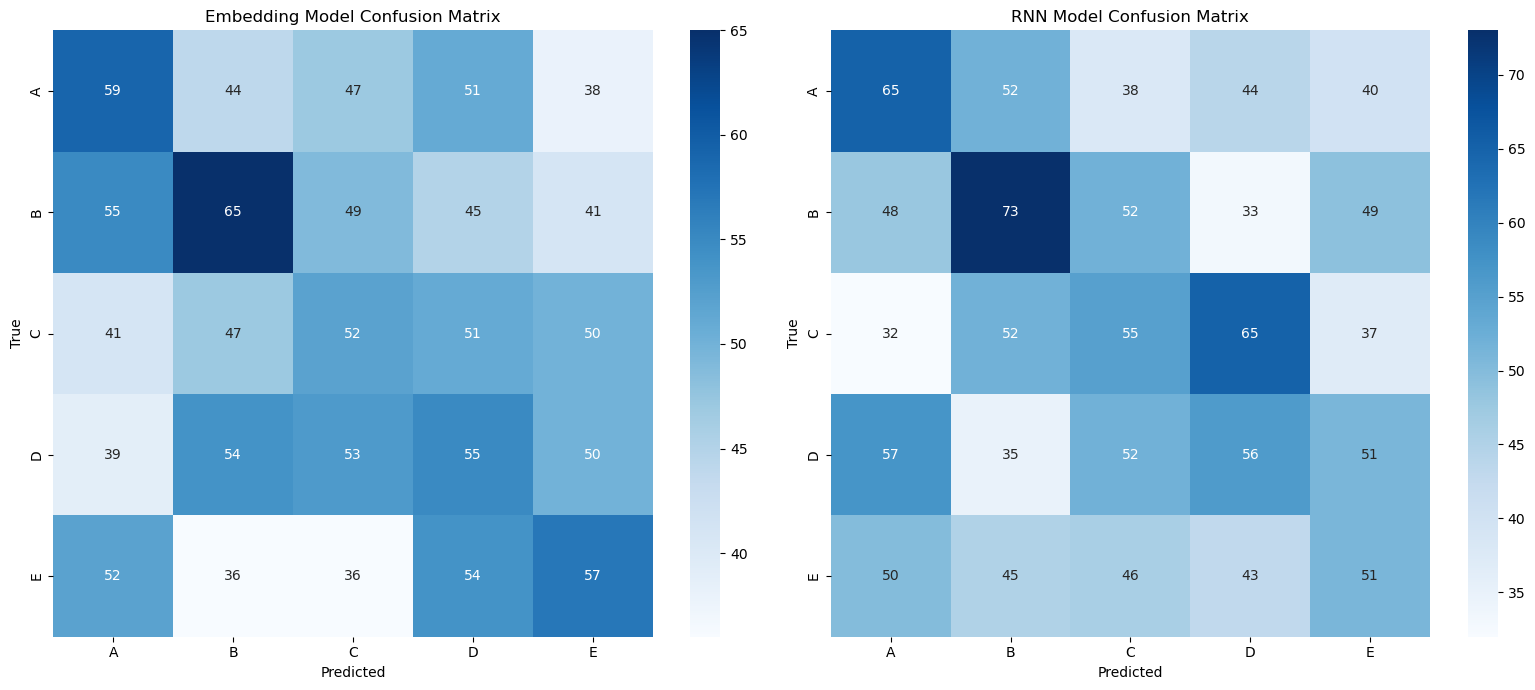

In [ ]:
print("\n===== CLASSIFICATION REPORTS =====")
print("\nEmbedding Model Classification Report:")
print(classification_report(embedding_labels, embedding_predictions, target_names=label_names, zero_division=0))

print("\nRNN Model Classification Report:")
print(classification_report(rnn_labels, rnn_predictions, target_names=label_names, zero_division=0))

embedding_cm = confusion_matrix(embedding_labels, embedding_predictions)
rnn_cm = confusion_matrix(rnn_labels, rnn_predictions)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.heatmap(embedding_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Embedding Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(rnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("RNN Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

## Example-Based Analysis

To better understand where the models differ, I look at specific test examples where their predictions don’t match.

- I show actual **questions and answer choices** from the dataset.
- For each case, I highlight the **true answer**, the **embedding model’s prediction**, and the **RNN model’s prediction**.
- This helps identify **question types** or phrasing that may confuse one model but not the other.

These real examples give more context to the metrics and help explain model behavior in practical terms.


In [ ]:
label_mapping = {i: chr(65 + i) for i in range(5)}

disagreement_indices = np.where(np.array(embedding_predictions) != np.array(rnn_predictions))[0]
print(f"\n===== MODEL DISAGREEMENTS =====")
print(f"Models disagree on {len(disagreement_indices)} examples ({len(disagreement_indices)/len(embedding_predictions)*100:.2f}%)")

print("\nExamples where models disagree:")
np.random.seed(42)
sample_indices = np.random.choice(disagreement_indices, min(5, len(disagreement_indices)), replace=False)

for i in sample_indices:
    idx = int(i)
    example = test[idx]
    print(f"\nQuestion: {example['question']}")
    for j, choice in enumerate(example["choices"]["text"]):
        print(f"{chr(65+j)}) {choice}")
    print(f"True Answer: {example['answerKey']}")
    print(f"Embedding Model Prediction: {label_mapping[embedding_predictions[idx]]}")
    print(f"RNN Model Prediction: {label_mapping[rnn_predictions[idx]]}")
    print("-" * 80)


===== MODEL DISAGREEMENTS =====
Models disagree on 823 examples (67.40%)

Examples where models disagree:

Question: If I wanted to grow plants, where could I put a lot of dirt?
A) corner
B) street
C) closet
D) garden
E) bathtub
True Answer: D
Embedding Model Prediction: B
RNN Model Prediction: D
--------------------------------------------------------------------------------

Question: If a person is working a lot, what are they likely trying to earn?
A) much money
B) own house
C) creativity
D) new car
E) caregiver
True Answer: A
Embedding Model Prediction: C
RNN Model Prediction: A
--------------------------------------------------------------------------------

Question: I did not need a servant.  I was not a what?
A) freedom
B) rich person
C) hired help
D) in charge
E) busy
True Answer: B
Embedding Model Prediction: C
RNN Model Prediction: B
--------------------------------------------------------------------------------

Question: What could a driving car do to a pedestrian?
A) s

## Correctness Pattern Analysis

I categorize test examples based on which model made the correct prediction:

- **Only embedding correct**
- **Only RNN correct**
- **Both correct**
- **Both incorrect**

This shows how often the models **complement each other** vs. making similar mistakes.

A high number of cases where only one model is correct suggests potential for **ensemble methods**. I also visualize these patterns to better understand how model behavior overlaps or diverges.



===== CORRECTNESS PATTERNS =====
Only Embedding Model Correct: 180 examples (14.74%)
Only RNN Model Correct: 192 examples (15.72%)
Both Models Correct: 108 examples (8.85%)
Both Models Incorrect: 741 examples (60.69%)


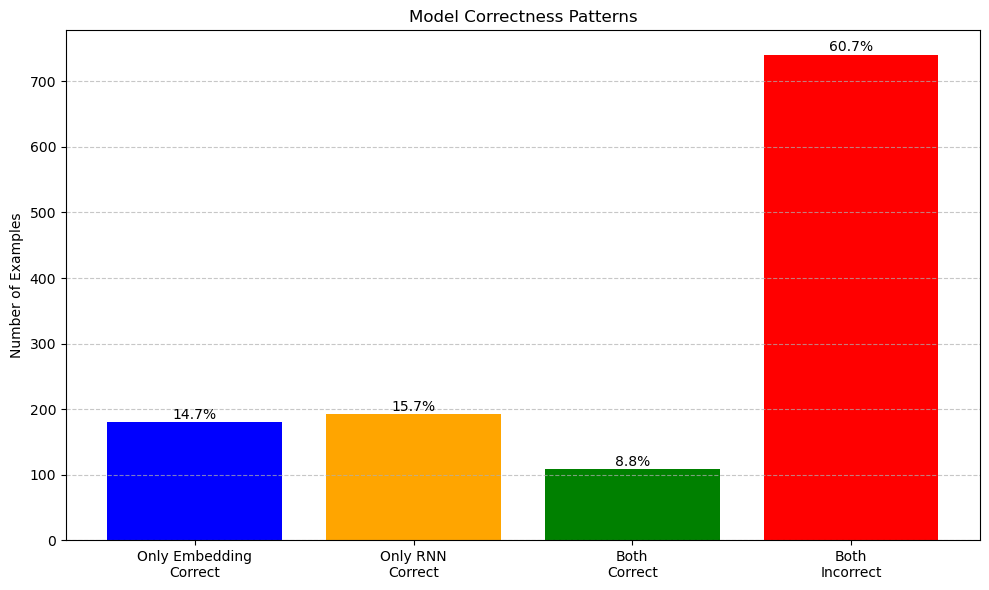

In [ ]:
embedding_correct = np.array(embedding_predictions) == np.array(embedding_labels)
rnn_correct = np.array(rnn_predictions) == np.array(rnn_labels)

only_embedding_correct = np.logical_and(embedding_correct, np.logical_not(rnn_correct))
only_rnn_correct = np.logical_and(rnn_correct, np.logical_not(embedding_correct))
both_correct = np.logical_and(embedding_correct, rnn_correct)
both_incorrect = np.logical_and(np.logical_not(embedding_correct), np.logical_not(rnn_correct))

print("\n===== CORRECTNESS PATTERNS =====")
print(f"Only Embedding Model Correct: {np.sum(only_embedding_correct)} examples ({np.sum(only_embedding_correct)/len(embedding_predictions)*100:.2f}%)")
print(f"Only RNN Model Correct: {np.sum(only_rnn_correct)} examples ({np.sum(only_rnn_correct)/len(embedding_predictions)*100:.2f}%)")
print(f"Both Models Correct: {np.sum(both_correct)} examples ({np.sum(both_correct)/len(embedding_predictions)*100:.2f}%)")
print(f"Both Models Incorrect: {np.sum(both_incorrect)} examples ({np.sum(both_incorrect)/len(embedding_predictions)*100:.2f}%)")

plt.figure(figsize=(10, 6))
categories = ['Only Embedding\nCorrect', 'Only RNN\nCorrect', 'Both\nCorrect', 'Both\nIncorrect']
values = [np.sum(only_embedding_correct), np.sum(only_rnn_correct), np.sum(both_correct), np.sum(both_incorrect)]

plt.bar(categories, values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Number of Examples')
plt.title('Model Correctness Patterns')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v + 5, f"{v/len(embedding_predictions)*100:.1f}%", ha='center')
    
plt.tight_layout()
plt.savefig('correctness_patterns.png')
plt.show()

### Question Type Distribution and Performance Comparison

I started by analyzing the distribution of question types across the training, validation, and test sets. The dataset is heavily skewed toward *what*, *where*, and *other* questions:

- **"What" questions** make up over 40% of each split.
- **"Where" questions** are the second most common, around 25%.
- Less frequent types like *who*, *how*, and *which* are underrepresented (<5%).

In the performance analysis:

- Both models perform similarly across most question types.
- The **RNN model outperforms the embedding model** on rarer types like *who* and *why*.
- For dominant categories like *what* and *where*, **both models perform similarly**, reflecting the strong training signal.
- Interestingly, the RNN also shows a slight edge on **"which"** questions, despite their low frequency.

This comparison shows that **data imbalance strongly influences performance**, but the RNN model generalizes better to underrepresented question types, possibly due to its ability to capture sequential patterns in language.



===== PERFORMANCE BY QUESTION TYPE =====
Question type 'how':
  Count: 32
  Embedding Accuracy: 0.1875
  RNN Accuracy: 0.1562
  Difference: 0.0312 in favor of Embedding model
Question type 'other':
  Count: 258
  Embedding Accuracy: 0.2287
  RNN Accuracy: 0.2481
  Difference: 0.0194 in favor of RNN model
Question type 'what':
  Count: 524
  Embedding Accuracy: 0.2156
  RNN Accuracy: 0.2156
  Difference: 0.0000 in favor of RNN model
Question type 'when':
  Count: 39
  Embedding Accuracy: 0.1538
  RNN Accuracy: 0.1538
  Difference: 0.0000 in favor of RNN model
Question type 'where':
  Count: 310
  Embedding Accuracy: 0.2968
  RNN Accuracy: 0.3032
  Difference: 0.0065 in favor of RNN model
Question type 'which':
  Count: 8
  Embedding Accuracy: 0.3750
  RNN Accuracy: 0.3750
  Difference: 0.0000 in favor of RNN model
Question type 'who':
  Count: 16
  Embedding Accuracy: 0.0625
  RNN Accuracy: 0.2500
  Difference: 0.1875 in favor of RNN model
Question type 'why':
  Count: 34
  Embedding A

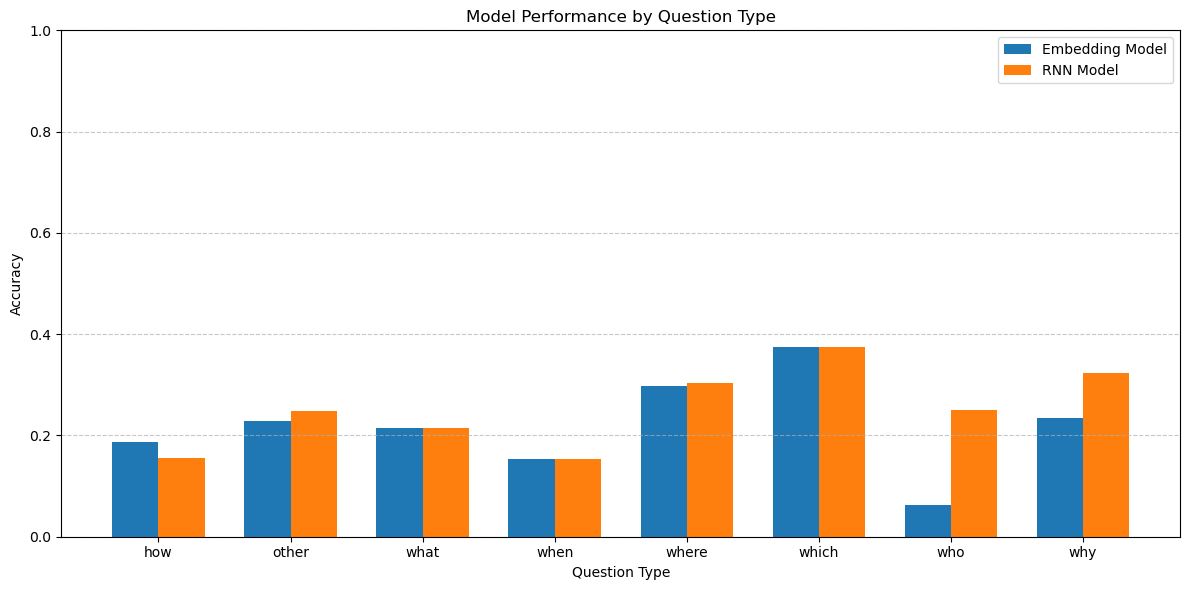

In [ ]:
print("\n===== PERFORMANCE BY QUESTION TYPE =====")
question_types = []
for idx in range(len(test)):
    question_type = get_question_type(test[idx]['question'])
    question_types.append(question_type)

question_types = np.array(question_types)
unique_types = np.unique(question_types)

embedding_by_type = []
rnn_by_type = []

for q_type in unique_types:
    type_indices = question_types == q_type
    if np.sum(type_indices) > 0:
        embedding_accuracy = np.mean(embedding_correct[type_indices])
        rnn_accuracy = np.mean(rnn_correct[type_indices])
        
        embedding_by_type.append(embedding_accuracy)
        rnn_by_type.append(rnn_accuracy)
        
        print(f"Question type '{q_type}':")
        print(f"  Count: {np.sum(type_indices)}")
        print(f"  Embedding Accuracy: {embedding_accuracy:.4f}")
        print(f"  RNN Accuracy: {rnn_accuracy:.4f}")
        print(f"  Difference: {abs(embedding_accuracy - rnn_accuracy):.4f} in favor of " 
              f"{'Embedding' if embedding_accuracy > rnn_accuracy else 'RNN'} model")

plt.figure(figsize=(12, 6))
x = np.arange(len(unique_types))
width = 0.35

plt.bar(x - width/2, embedding_by_type, width, label='Embedding Model')
plt.bar(x + width/2, rnn_by_type, width, label='RNN Model')

plt.xlabel('Question Type')
plt.ylabel('Accuracy')
plt.title('Model Performance by Question Type')
plt.xticks(x, unique_types)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('performance_by_question_type.png')
plt.show()

# Conclusion

## Tools and Resources Used

This project was implemented using the following tools and resources:

1. **Libraries and Frameworks**:
   - PyTorch for neural network implementation and training
   - Hugging Face Datasets for data loading and preprocessing
   - NLTK for tokenization and text processing
   - Gensim for working with word embeddings
   - Pandas and NumPy for data manipulation
   - Matplotlib and Seaborn for visualization
   - Scikit-learn for evaluation metrics

2. **Pre-trained Resources**:
   - FastText word embeddings (Common Crawl, 2M word vectors)
   - NLTK's pre-trained tokenizer

3. **Experiment Tracking**:
   - Weights & Biases for logging metrics and visualizing training progress

4. **Development Environment**:
   - Jupyter Notebook for interactive development
   - Google Colab for GPU-accelerated training

5. **AI Tools**:
   - Claude 3.5 Sonnet for help with debugging and optimizing code
   - GitHub Copilot for code suggestions and documentation

This toolkit provided the necessary components for building, training, and evaluating models for the CommonsenseQA task while enabling detailed analysis and documentation of the project workflow.